# IMPORT LIBRARIES

In [0]:
import json
import requests

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

sns.set_palette('Set2')
%matplotlib inline

# DATA

In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
cd /content/drive/My Drive/nus_blockchain

/content/drive/My Drive/nus_blockchain


In [0]:
import zipfile

zip_ref = zipfile.ZipFile("/content/drive/My Drive/nus_blockchain/bitcoin-historical-data.zip", 'r')
zip_ref.extractall()
zip_ref.close()
data = pd.read_csv('/content/drive/My Drive/nus_blockchain/bitstampUSD_1-min_data_2012-01-01_to_2019-08-12.csv')
data.isnull().values.any()
data = data.dropna(how='any',axis=0)

In [93]:
data['date'] = pd.to_datetime(data['Timestamp'],unit='s').dt.date
group = data.groupby('date')
Daily_Price = group['Weighted_Price'].mean()

Daily_Price.head()

date
2011-12-31    4.471603
2012-01-01    4.806667
2012-01-02    5.000000
2012-01-03    5.252500
2012-01-04    5.208159
Name: Weighted_Price, dtype: float64

In [94]:
data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,date
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31
478,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011-12-31
547,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411,2011-12-31
548,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011-12-31
1224,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2012-01-01


In [0]:
#endpoint = 'https://min-api.cryptocompare.com/data/histoday'
#res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=2000')
#data = pd.DataFrame(json.loads(res.content)['Data'])
#data = data.set_index('time')
#data.index = pd.to_datetime(data.index, unit='s')
#target_col = 'close'

In [95]:
data.head()



,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,date
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31
478,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011-12-31
547,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411,2011-12-31
548,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011-12-31
1224,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2012-01-01


In [0]:
def train_test_split(df, test_size=0.1):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [97]:
train, test = train_test_split(hist, test_size=0.1)
print("Train Size:",train.size)
print("Test Size:",test.size)

Train Size: 10806
Test Size: 1200


# EXPLORATORY DATA ANALYSIS

In [0]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18);

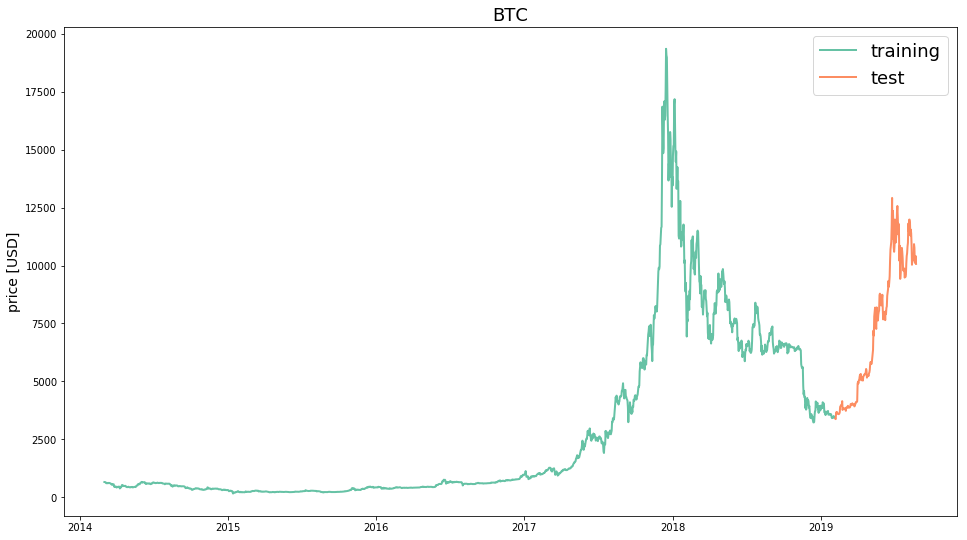

In [99]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='BTC')

# LSTM

In [0]:
def normalise_zero_base(df):
    """ Normalise dataframe column-wise to reflect changes with respect to first entry. """
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    """ Normalise dataframe column-wise min/max. """
    return (df - df.min()) / (data.max() - df.min())

In [0]:
def extract_window_data(df, window_len=10, zero_base=True):
    """ Convert dataframe to overlapping sequences/windows of len `window_data`.
    
        :param window_len: Size of window
        :param zero_base: If True, the data in each window is normalised to reflect changes
            with respect to the first entry in the window (which is then always 0)
    """
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [0]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    """ Prepare data for LSTM. """
    # train test split
    train_data, test_data = train_test_split(df, test_size=test_size)
    
    # extract window data
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    
    # extract targets
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [0]:
def build_lstm_model(input_data, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [0]:
np.random.seed(42)

# data params
window_len = 7
test_size = 0.1
zero_base = True

# model params
lstm_neurons = 20
epochs = 50
batch_size = 4
loss = 'mae'
dropout = 0.25
optimizer = 'adam'

In [0]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [108]:
train.size

10806

# MODEL

In [109]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
1794/1794 [==============================] - 3s 2ms/step - loss: 0.0525
Epoch 2/50
1794/1794 [==============================] - 2s 1ms/step - loss: 0.0381
Epoch 3/50
1794/1794 [==============================] - 2s 1ms/step - loss: 0.0337
Epoch 4/50
1794/1794 [==============================] - 2s 1ms/step - loss: 0.0318
Epoch 5/50
1794/1794 [==============================] - 2s 1ms/step - loss: 0.0307
Epoch 6/50
1794/1794 [==============================] - 2s 1ms/step - loss: 0.0305
Epoch 7/50
1794/1794 [==============================] - 3s 1ms/step - loss: 0.0294
Epoch 8/50
1794/1794 [==============================] - 3s 1ms/step - loss: 0.0293
Epoch 9/50
1794/1794 [==============================] - 3s 1ms/step - loss: 0.0292
Epoch 10/50
1794/1794 [==============================] - 2s 1ms/step - loss: 0.0284
Epoch 11/50
1794/1794 [==============================] - 3s 1ms/step - loss: 0.0295
Epoch 12/50
1794/1794 [==============================] - 3s 1ms/step - loss: 0.0289
E

In [0]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()

In [118]:
print("Target:",y_test[12])
print("Prediction:",preds[12])

Target: -0.017139629450719118
Prediction: -0.01760861


# Error Estimation

In [119]:
mean_absolute_error(preds, y_test)

0.029014153534285596

# DATA PLOT

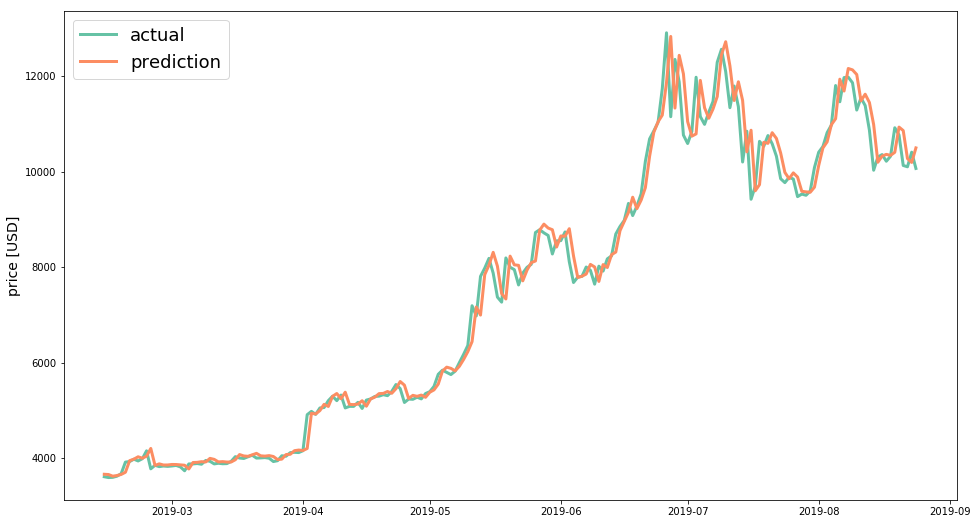

In [120]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)

line_plot(targets, preds, 'actual', 'prediction', lw=3)

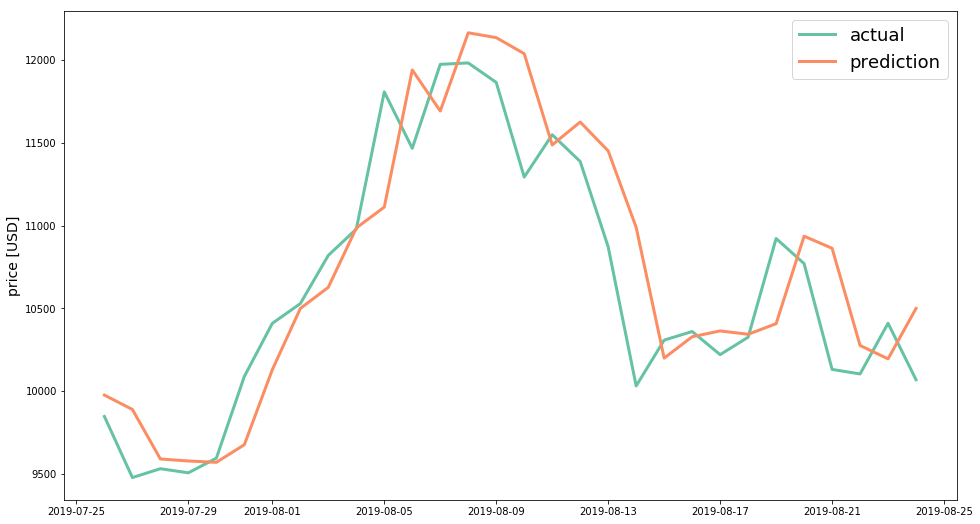

In [121]:
n_points = 30

line_plot(targets[-n_points:], preds[-n_points:], 'actual', 'prediction', lw=3)

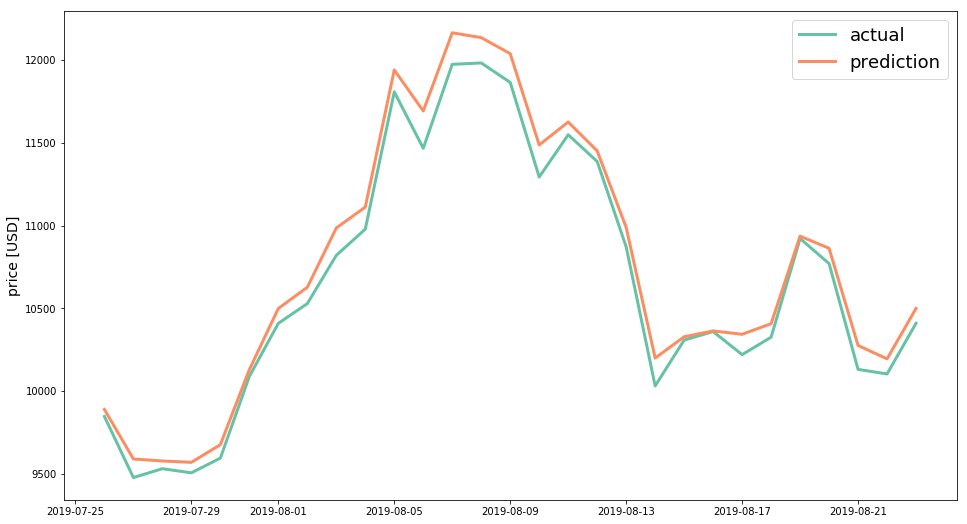

In [122]:
line_plot(targets[-n_points:][:-1], preds[-n_points:].shift(-1), 'actual', 'prediction', lw=3)

In [0]:
actual_returns = targets.pct_change()[1:]
predicted_returns = preds.pct_change()[1:]

In [0]:
def dual_line_plot(line1, line2, line3, line4, label1=None, label2=None, title='', lw=2):
    import matplotlib.dates as mdates
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 9))
    ax1.plot(line1, label=label1, linewidth=lw)
    ax1.plot(line2, label=label2, linewidth=lw)
    ax2.plot(line3, label=label1, linewidth=lw)
    ax2.plot(line4, label=label2, linewidth=lw)
    ax2.set_xticks(ax1.get_xticks())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.set_ylabel('daily returns', fontsize=14)
    ax2.legend(loc='best', fontsize=18);

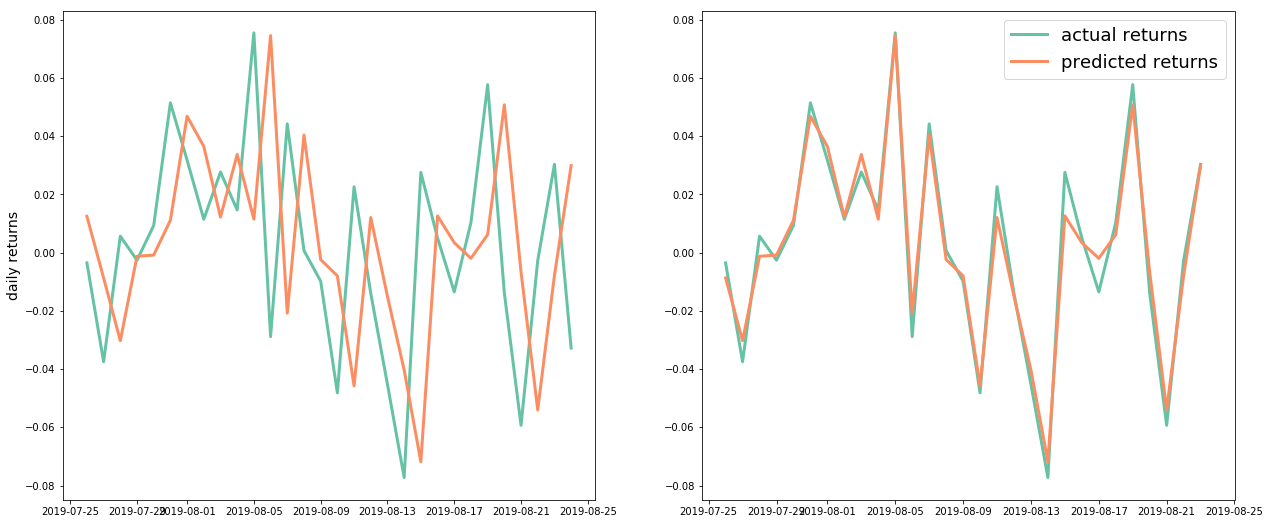

In [125]:
dual_line_plot(actual_returns[-n_points:],
          predicted_returns[-n_points:],
          actual_returns[-n_points:][:-1],
          predicted_returns[-n_points:].shift(-1),
          'actual returns', 'predicted returns', lw=3)

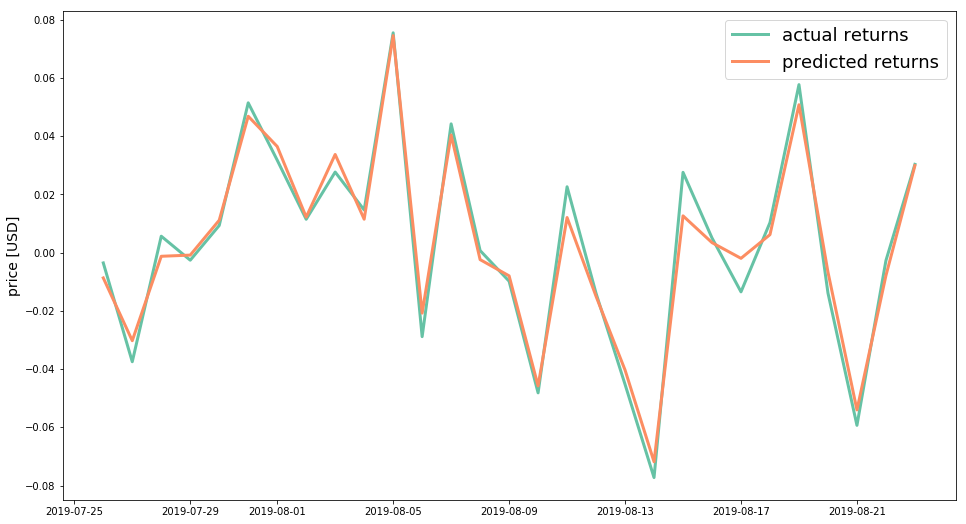

In [126]:
line_plot(actual_returns[-n_points:][:-1], predicted_returns[-n_points:].shift(-1),
           'actual returns', 'predicted returns', lw=3)

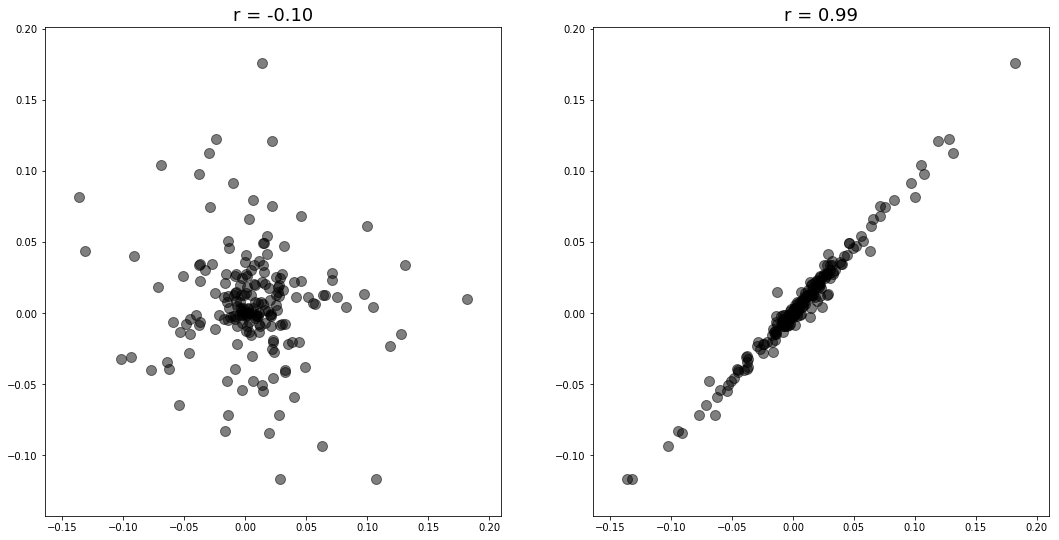

In [127]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

# actual correlation
corr = np.corrcoef(actual_returns, predicted_returns)[0][1]
ax1.scatter(actual_returns, predicted_returns, color='k', marker='o', alpha=0.5, s=100)
ax1.set_title('r = {:.2f}'.format(corr), fontsize=18)

# shifted correlation
shifted_actual = actual_returns[:-1]
shifted_predicted = predicted_returns.shift(-1).dropna()
corr = np.corrcoef(shifted_actual, shifted_predicted)[0][1]
ax2.scatter(shifted_actual, shifted_predicted, color='k', marker='o', alpha=0.5, s=100)
ax2.set_title('r = {:.2f}'.format(corr), fontsize=18);